# Importing Libraries

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import requests

# Data Cleaning & Preprocessing

In [2]:
# these are the necessary series that are needed for this project
necessary_series = ["country", "date", "total_cases", "new_cases", "total_deaths", "new_deaths", "total_vaccinations", "new_vaccinations", "hosp_patients", "continent", "population"]

# reading the data CSV file
df_main = pd.read_csv("./compact.csv", usecols=necessary_series)

In [3]:
# finding the null values in dataset
df_main.isnull().sum()

# checking the datatypes of the series
df_main.dtypes

# list of numeric columns which have null values
null_value_cols = ["total_cases", "new_cases", "total_deaths", "new_deaths", "hosp_patients", "total_vaccinations", "new_vaccinations", "population"]

# creating a dictionary for column name: value pairs
null_value_dict = {column: 0 for column in null_value_cols}

# filling the null values in numeric columns with zeroes
df_primary = df_main.fillna(null_value_dict)

# now, checking why continent is null
df_primary.loc[df_primary["continent"].isnull()]

# so clearly, rows which have country name that of a continent and an invalid country name have continent column = NaN
# dropping those rows which have continent = NaN
df_primary.dropna(subset=["continent"], axis=0, inplace=True)

# changing the datatype of date column to datetime
df_primary["date"] = df_primary["date"].astype(dtype="datetime64[s]")

# Filtering & Grouping Data

In [4]:
# creating two extra series, one for month and one year
months = df_primary["date"].dt.month_name()
month_nums = df_primary["date"].dt.month
years = df_primary["date"].dt.year
df_primary["month"] = months
df_primary["month_number"] = month_nums
df_primary["year"] = years

# grouping the data into useful groups
df_countries = df_primary.groupby("country")
df_continents = df_primary.groupby("continent")
df_timeline = df_primary.groupby(["year", "month_number"])

# Trend Analysis

In [ ]:
# finding the top 10 countries by deaths and cases
top_countries_by_deaths = df_countries["total_deaths"].sum().sort_values(ascending=False).iloc[0:10].index
top_countries_by_deaths

top_countries_by_cases = df_countries["total_cases"].sum().sort_values(ascending=False).iloc[0:10].index
top_countries_by_cases

# getting all the data for the top countries
df_top_countries_by_deaths = df_primary[df_primary["country"].isin(top_countries_by_deaths)]
df_top_countries_by_deaths

df_top_countries_by_cases = df_primary[df_primary["country"].isin(top_countries_by_cases)]
df_top_countries_by_cases

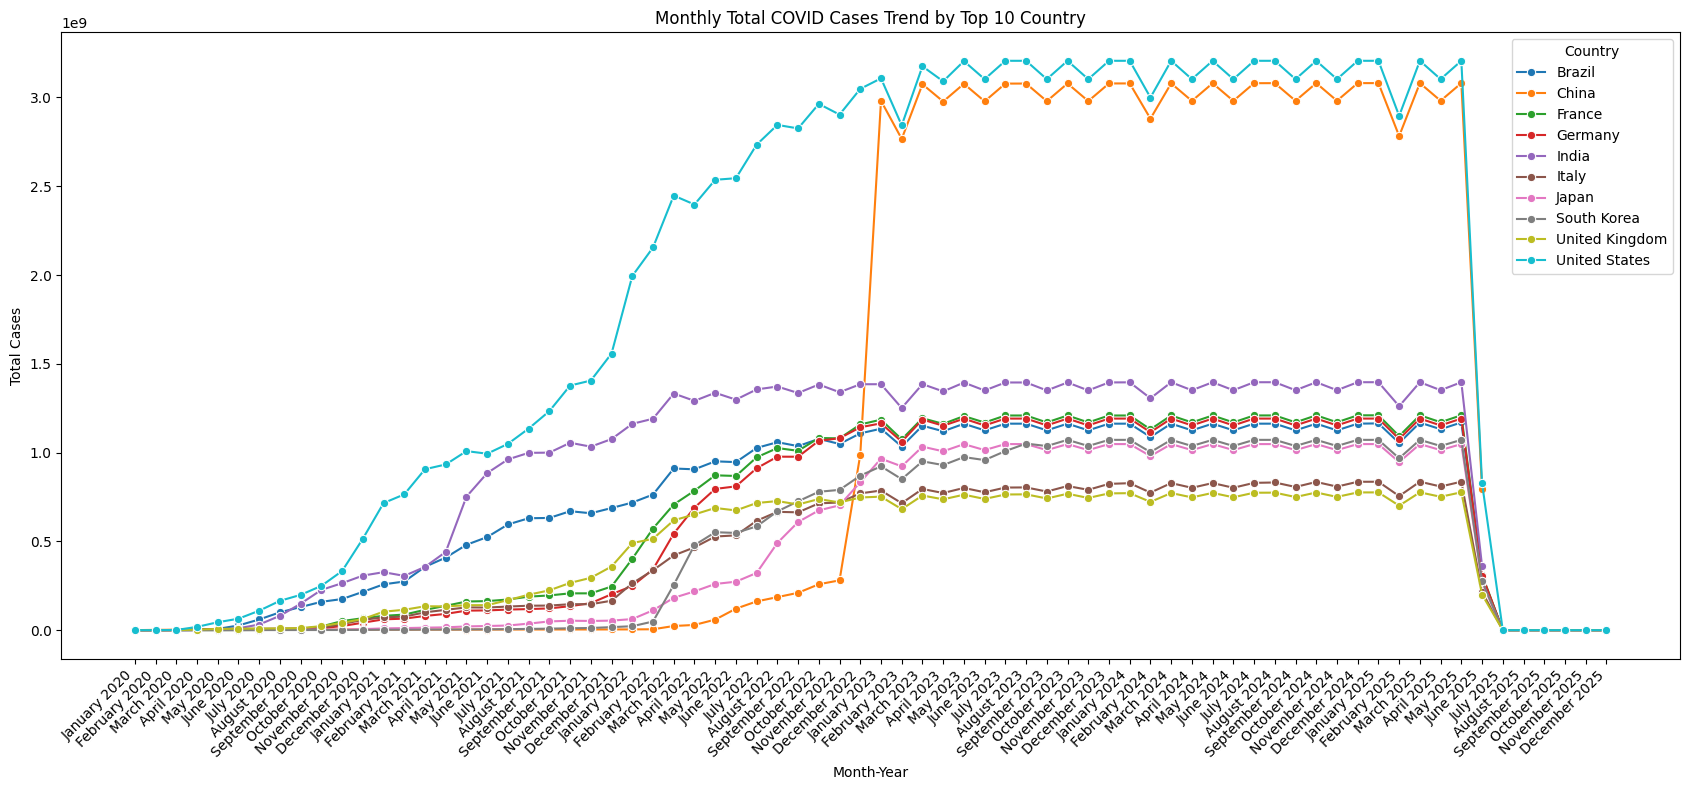

In [6]:
# Monthly Commulative case trends for top countries
df_monthly_trends = df_top_countries_by_cases.groupby(["country", "year", "month_number"])["total_cases"].sum().reset_index()
df_monthly_trends.sort_values(by=["country", "year", "month_number"], inplace=True)

# creating a proper datetime column using year and month
df_monthly_trends["month_year"] = pd.to_datetime(
    df_monthly_trends["year"].astype(str) + "-" + df_monthly_trends["month_number"].astype(str).str.zfill(2)
)

# formatting as "Month YYYY"
df_monthly_trends["month_year"] = df_monthly_trends["month_year"].dt.strftime("%B %Y")

# plotting a line graph for all countries
plt.figure(figsize=(17, 8))
sns.lineplot(data=df_monthly_trends, x="month_year", y="total_cases", hue="country", marker="o")

# improving the plot
plt.xticks(rotation=45, ha='right')
plt.title('Monthly Total COVID Cases Trend by Top 10 Country')
plt.xlabel('Month-Year')
plt.ylabel('Total Cases')
plt.tight_layout()
plt.legend(title='Country')
plt.savefig("./output/monthly_cases_trend.png", dpi=300)
plt.show()

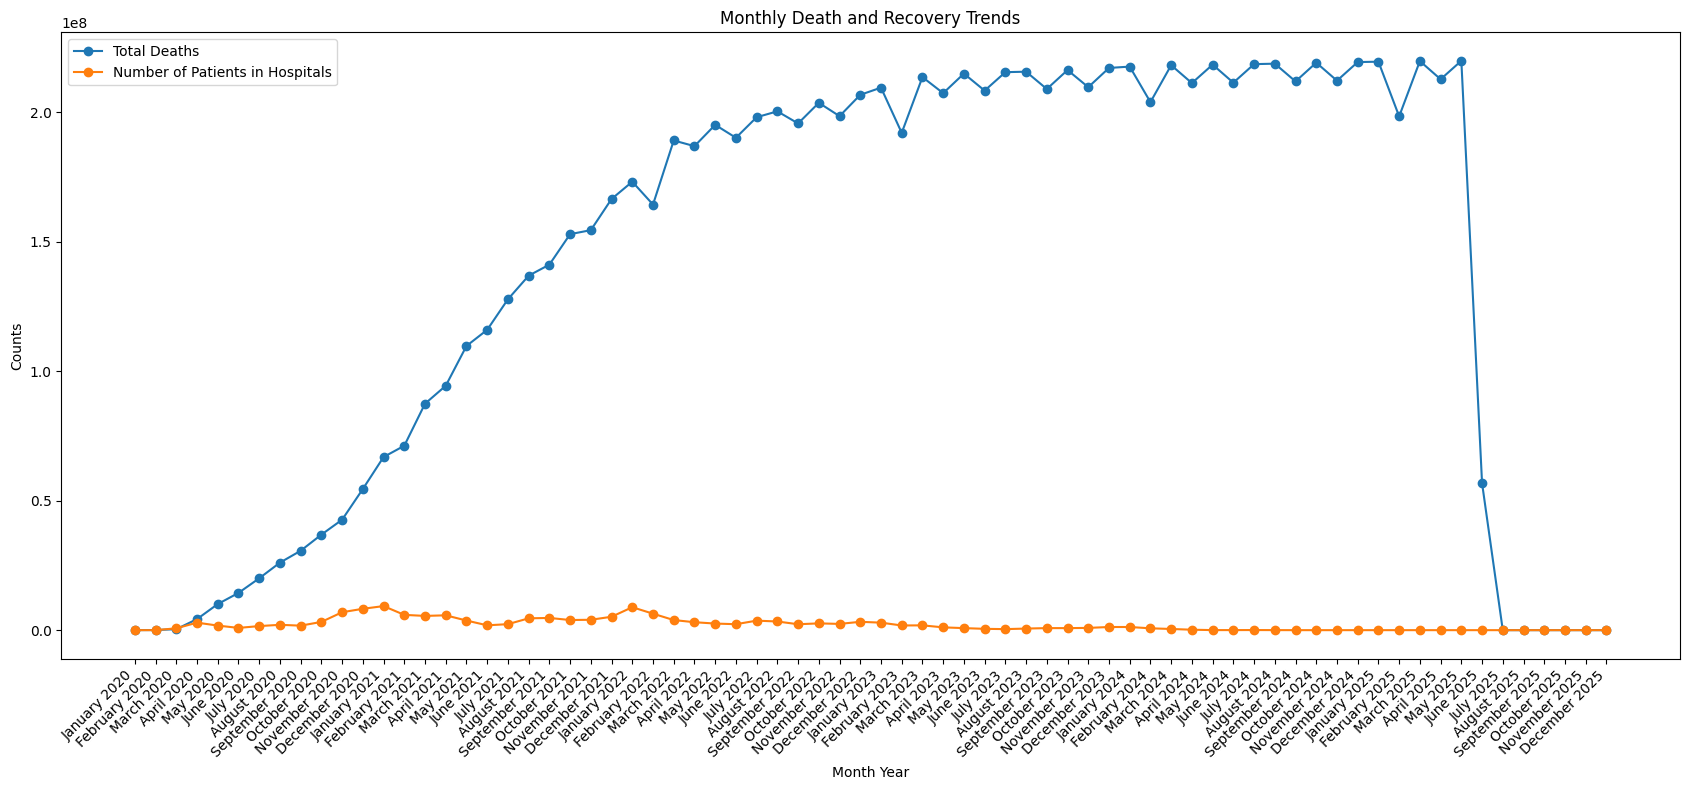

In [7]:
# deaths and recovery trends over time
# creating the useful dataframes
df_death_and_recovery_trends = df_timeline[["total_deaths", "hosp_patients"]].sum().reset_index()

# adding a month_year new series for deaths dataframe
df_death_and_recovery_trends["month_year"] = pd.to_datetime(
    df_death_and_recovery_trends["year"].astype(str) + "-" + df_death_and_recovery_trends["month_number"].astype(str).str.zfill(2)
)

# formatting as "Month YYYY"
df_death_and_recovery_trends["month_year"] = df_death_and_recovery_trends["month_year"].dt.strftime("%B %Y")

df_death_and_recovery_trends.sort_values(by=["year", "month_number"], inplace=True)

# renaming the columns for better understanding
df_death_and_recovery_trends.rename(columns={"total_deaths": "Total Deaths", "hosp_patients": "Number of Patients in Hospitals"}, inplace=True)

# plotting the graph
ax = df_death_and_recovery_trends.plot(
    figsize=(17, 8), marker="o", x="month_year",
    y=["Total Deaths", "Number of Patients in Hospitals"]
)

# force all ticks to show
ax.set_xticks(range(len(df_death_and_recovery_trends["month_year"])))
ax.set_xticklabels(df_death_and_recovery_trends["month_year"], rotation=45, ha="right")

plt.title("Monthly Death and Recovery Trends")
plt.xlabel("Month Year")
plt.ylabel("Counts")
plt.tight_layout()
plt.savefig("./output/death_and_recovery_trend.png", dpi=300)
plt.show()

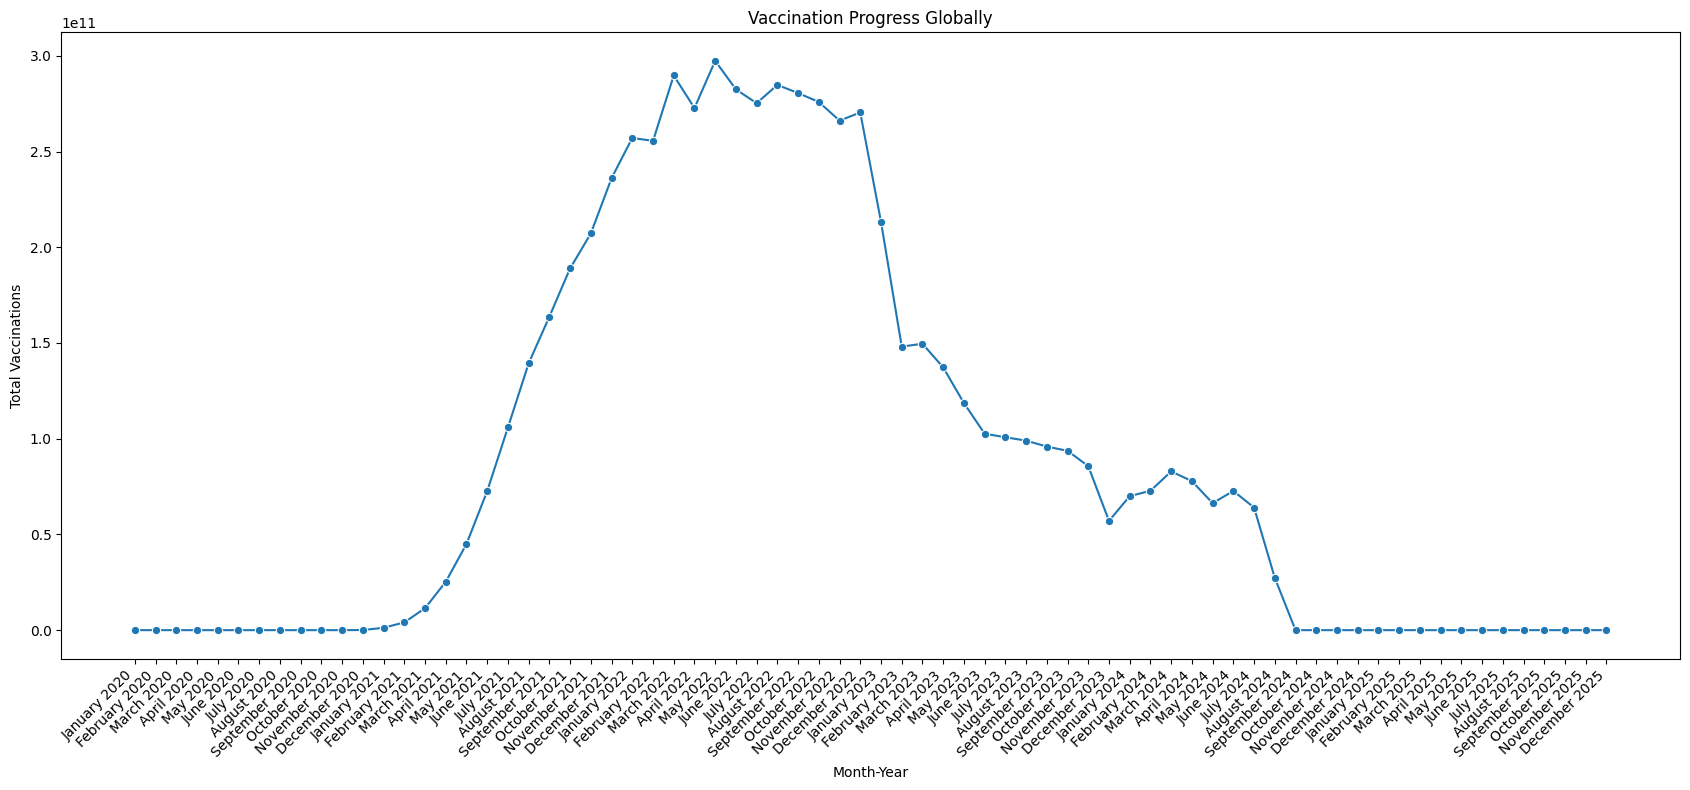

In [8]:
# Vaccination Progress Globally
df_vaccination_trends = df_timeline["total_vaccinations"].sum().reset_index()

# adding a month_year new series for deaths dataframe
df_vaccination_trends["month_year"] = pd.to_datetime(
    df_vaccination_trends["year"].astype(str) + "-" + df_vaccination_trends["month_number"].astype(str).str.zfill(2)
)

# formatting as "Month YYYY"
df_vaccination_trends["month_year"] = df_vaccination_trends["month_year"].dt.strftime("%B %Y")

df_vaccination_trends.sort_values(by=["year", "month_number"], inplace=True)

# plotting a line graph for all countries
plt.figure(figsize=(17, 8))
sns.lineplot(data=df_vaccination_trends, x="month_year", y="total_vaccinations", marker="o")

# improving the plot
plt.xticks(rotation=45, ha='right')
plt.title('Vaccination Progress Globally')
plt.xlabel('Month-Year')
plt.ylabel('Total Vaccinations')
plt.tight_layout()
plt.savefig("./output/global_vaccination_trend.png", dpi=300)
plt.show()

# Comparative Visualizations

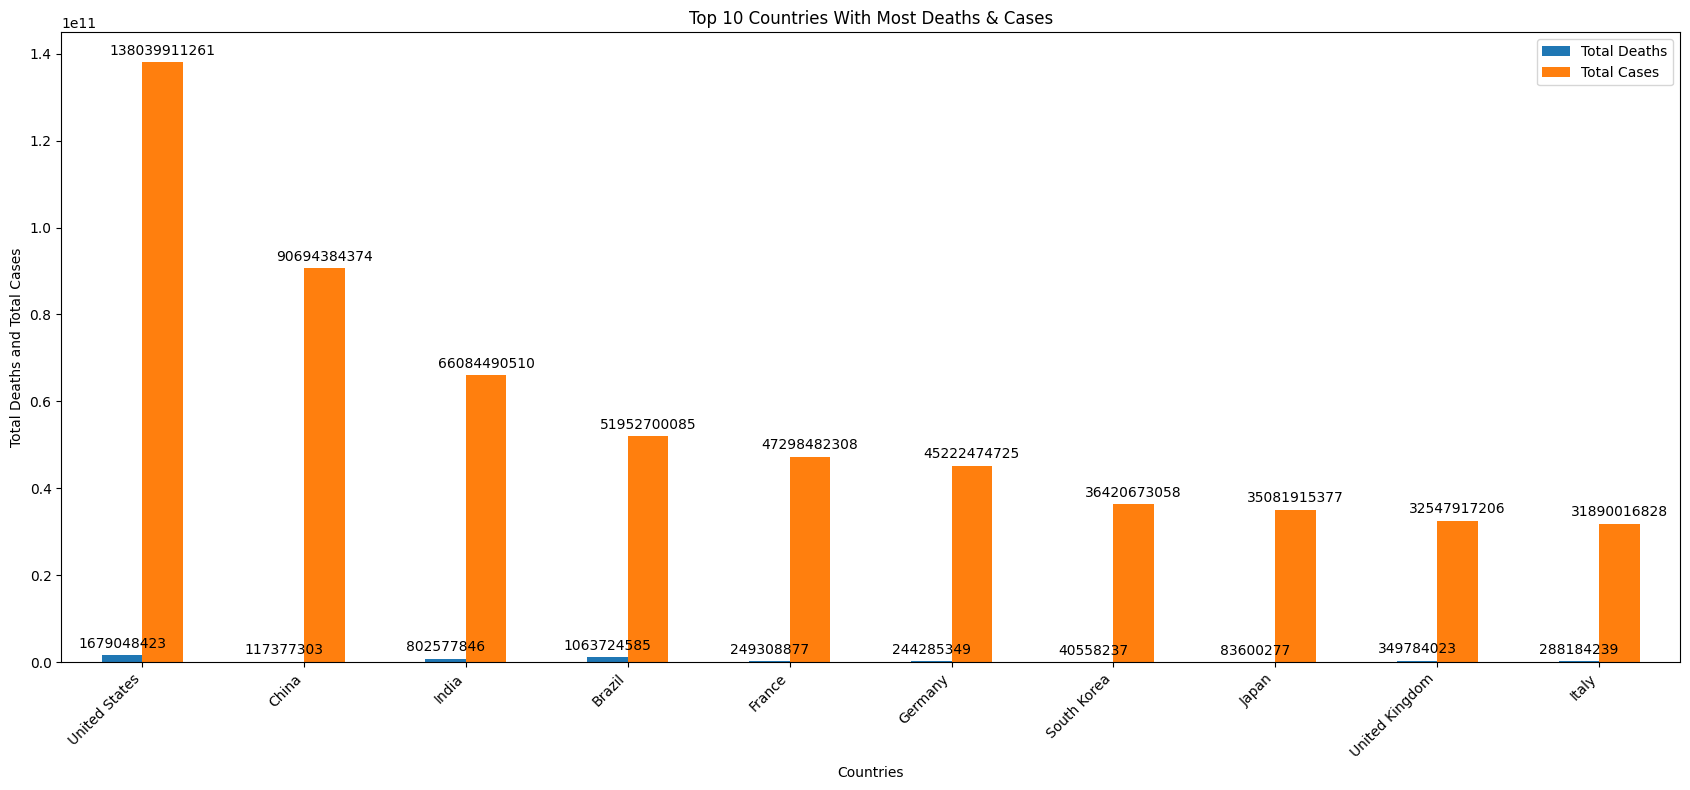

In [9]:
# Bar plot for top 10 countries by total deaths and cases
df_top_countries = df_countries[["total_deaths", "total_cases"]].sum().reset_index()
df_top_countries.rename(columns={"total_deaths": "Total Deaths", "total_cases": "Total Cases"}, inplace=True)
df_top_countries["total_counts"] = df_top_countries["Total Cases"] + df_top_countries["Total Deaths"]
df_top_countries.sort_values(by=["total_counts"], ascending=False, inplace=True)
top10 = df_top_countries.iloc[0:10]

# Plot
ax = top10.plot(kind="bar", x="country", y=["Total Deaths", "Total Cases"], figsize=(17, 8))
plt.xlabel("Countries")
plt.ylabel("Total Deaths and Total Cases")
plt.title("Top 10 Countries With Most Deaths & Cases")

# Add value labels on top of bars
for container in ax.containers:
    ax.bar_label(container, fmt="%.0f", label_type='edge', padding=3)

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig("./output/top_countries_by_deaths_and_cases.png", dpi=300)
plt.show()

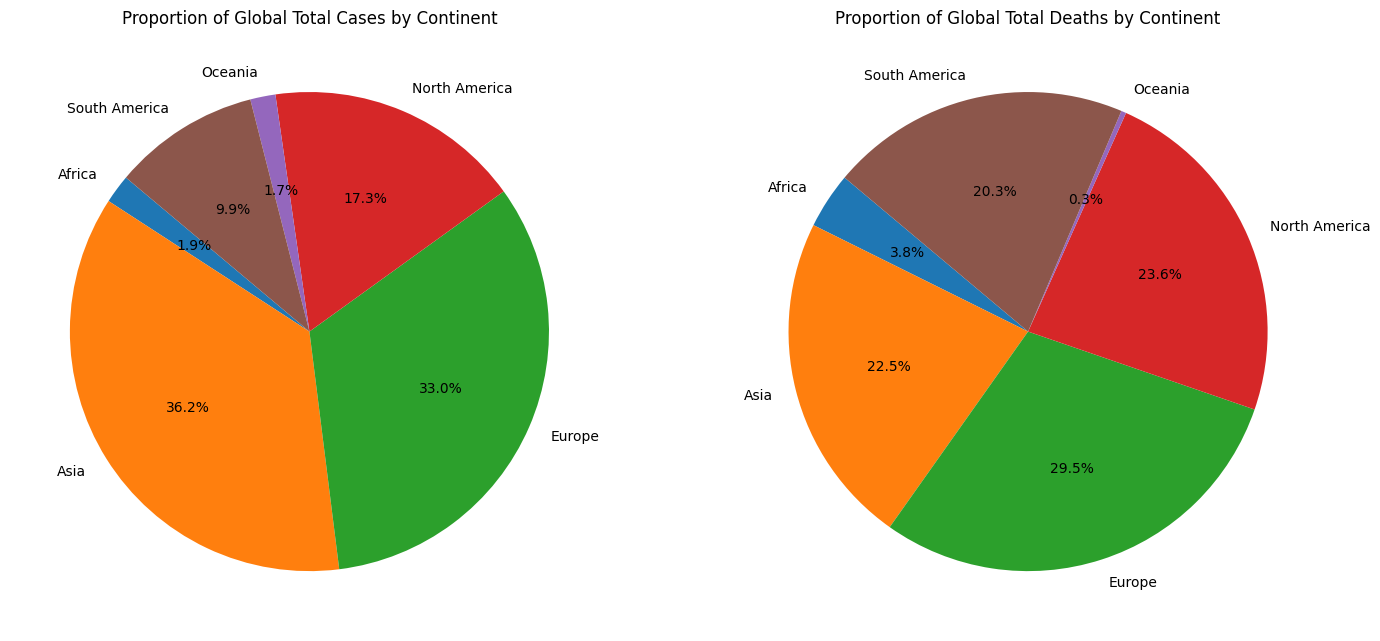

In [10]:
# Proportion of Global Cases and Deaths By Continents
df_global = df_continents[["total_cases", "total_deaths"]].sum().reset_index()
df_global.rename(columns={"total_deaths": "Total Deaths", "total_cases": "Total Cases"}, inplace=True)

# creating 2 plots using matplotlibs subplots
fig, axs = plt.subplots(1, 2, figsize=(17, 8)) # 1 row and 2 columns
df_global.set_index("continent")["Total Cases"].plot(kind="pie", ax=axs[0], ylabel="", autopct="%1.1f%%", shadow=False, startangle=140, title="Proportion of Global Total Cases by Continent")
df_global.set_index("continent")["Total Deaths"].plot(kind="pie", ax=axs[1], ylabel="", autopct="%1.1f%%", shadow=False, startangle=140, title="Proportion of Global Total Deaths by Continent")
plt.savefig("./output/continental_proportions_of_deaths_and_cases.png", dpi=300)
plt.show()

# Geospatial Visualization

In [ ]:
# Visualizing Total Number of Cases in Every Country
df_global_cases = df_countries["total_cases"].sum().reset_index()

# Country name correction mapping
country_name_corrections = {
    "United States": "United States of America",
    "Serbia": "Republic of Serbia",
    # "Russia": "Russian Federation",
    # "Iran": "Iran (Islamic Republic of)",
    # "Vietnam": "Viet Nam",
    # "South Korea": "Republic of Korea",
    # "North Korea": "Democratic People's Republic of Korea",
    # "Syria": "Syrian Arab Republic",
    "Czechia": "Czech Republic",
    "Tanzania": "United Republic of Tanzania",
    # "Venezuela": "Venezuela (Bolivarian Republic of)",
    "North Macedonia": "Macedonia",
    # "Bolivia": "Bolivia (Plurinational State of)",
    # "Laos": "Lao People's Democratic Republic",
    # "Brunei": "Brunei Darussalam",
    # "Palestine": "Palestine, State of",
    # "Ivory Coast": "Côte d'Ivoire",
    "Congo": "Republic of the Congo",
}

# Get Congo's total cases
congo_value = df_global_cases[df_global_cases["country"] == "Congo"]["total_cases"].values[0]

# Drop the original 'Congo' row
df_global_cases = df_global_cases[df_global_cases["country"] != "Congo"]

# Create a new DataFrame with two rows for both Congos
congo_rows = pd.DataFrame([
    {"country": "Democratic Republic of the Congo", "total_cases": congo_value},
    {"country": "Republic of the Congo", "total_cases": congo_value}
])

# Concatenate the new rows
df_global_cases = pd.concat([df_global_cases, congo_rows], ignore_index=True)


# Apply correction
df_global_cases["country"] = df_global_cases["country"].replace(country_name_corrections)

# Load GeoJSON from GitHub
world_geo = requests.get('https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/world-countries.json').json()

# Create base world map
world_map = folium.Map(location=[20, 0], zoom_start=2)

# Merge data into GeoJSON properties
for feature in world_geo["features"]:
    country_name = feature["properties"]["name"]
    matching_row = df_global_cases[df_global_cases["country"] == country_name]
    if not matching_row.empty:
        total = int(matching_row["total_cases"].values[0])
        feature["properties"]["total_cases"] = f"{total:,}"
    else:
        feature["properties"]["total_cases"] = "No data"

# Add choropleth
folium.Choropleth(
    geo_data=world_geo,
    data=df_global_cases,
    columns=["country", "total_cases"],
    key_on="feature.properties.name",
    fill_color="YlOrRd",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Total COVID-19 Cases by Country",
).add_to(world_map)

# Add interactive tooltips and popups
folium.GeoJson(
    world_geo,
    name="Countries",
    style_function=lambda x: {"fillOpacity": 0, "color": "transparent"},
    tooltip=folium.GeoJsonTooltip(
        fields=["name", "total_cases"],
        aliases=["Country", "Total Cases"],
        localize=True,
        sticky=False,
        labels=True,
        style=("background-color: white; color: #333333; font-family: Arial; font-size: 12px; padding: 5px;"),
    )
).add_to(world_map)

# Save or display map
world_map.save("output/total_cases_tooltip_map.html")
world_map